In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import transformers as ppb
import time

 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from spellchecker import SpellChecker

import string
 
from nltk import FreqDist
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
import gensim
from gensim import corpora, models 
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\myin9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\myin9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\myin9\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
import torch
print(torch.__version__)

1.13.1+cpu


In [3]:
start = time.time()

df = pd.read_csv(r"C:\Users\myin9\Documents\career\ESG\financial_esg_text.csv")

for i in range(df.shape[1]):
    print(f"Length of column {i}: {df.iloc[:, i].str.len().sum()}")
    
end = time.time()
print("Time taken:", end - start, "seconds") # ime taken: 2.134260416030884 seconds

Length of column 0: 20269
Length of column 1: 176462747
Time taken: 1.824721336364746 seconds


In [4]:
df

,file,text
0,abn-amro-bank_2011.pdf,sustainability report\n2011\n\nA better bank f...
1,abn-amro-bank_2012.pdf,sustainability report \nsustainability report ...
2,abn-amro-bank_2013.pdf,sustainability report \n2013\n\nA better bank\...
3,abn-amro-bank_2014.pdf,...
4,abn-amro-bank_2018.pdf,ABN AMRO Group N.V.\n\nImpact Report 2018\n\nI...
...,...,...
1119,vienna-insurance-group_2018.pdf,CUSTOMERS\n\nENVIRONMENT\n\nCORE BUSINESS\n\nE...
1120,vienna-insurance-group_2019.pdf,O\nN\nD\nE\nJ\nA\nZ\n\nN\nE\nM\nM\nA\nS\n\nS\n...
1121,vienna-insurance-group_2020.pdf,Protecting\nwhat\nwill\nmatter.\n\ne\n\np\n\np...
1122,zurich_2019.pdf,Zurich Insurance Group\n\nSustainability \nhi...


# data cleaning

In [5]:
# Text cleaning function
def clean_text(text):
    text = text.lower() # Convert text to lowercase
    # Remove escape characters and line breaks
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\r', '', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub('\[.*?\]', '', text) # Remove text in square brackets
    # Remove text within brackets or parentheses
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'\[[^]]*\]', '', text)
    # Remove single characters, unless they are part of a two-letter word
    text = re.sub(r'\b\w\b', '', text)
    text = re.sub(r'\s[a-zA-Z]\s', ' ', text)   
    text = re.sub(r'[^a-zA-Z\s]', '', text)# Remove punctuation, digits, and non-English characters
#     text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    text = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    return text

# Clean the text data
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [7]:
# calculate the average length of strings in the 'col1' column
average_length = df['text'].str.len().mean()

# print the result
print("Average length:", average_length) # on average a file has141,612 words after rough cleaning

Average length: 141612.84697508896


## get rid of company and country names
### show up too often in results

In [6]:
# Extract words from file names and generate list
file_list = []
for file_name in df['file']:
    # Remove hyphens, underscores, and periods from the file name
    file_name = re.sub(r'[-_.]', ' ', file_name)
    # Split the file name into words
    words = file_name.split()
    # Add words to list
    for word in words:
        file_list.append(word.lower())

# Remove duplicates from the list and sort from a to z
# Extract words from file names and generate list
file_list = sorted(list(set(file_list)))
print(file_list)

['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', 'a', 'aagiy', 'ab', 'abn', 'acgl', 'acid', 'adm', 'ads', 'aef', 'afg', 'afl', 'ag', 'aibg', 'aig', 'aiz', 'ajg', 'alex', 'all', 'ally', 'amal', 'amlty', 'amp', 'amro', 'aon', 'aox', 'apo', 'argo', 'ashm', 'assurances', 'asx', 'ath', 'av', 'axa', 'axactor', 'axis', 'axp', 'az', 'bam', 'banca', 'bank', 'banque', 'barc', 'bayernlb', 'belfius', 'ben', 'bk', 'bloomberg', 'bmo', 'bns', 'boq', 'bper', 'bpop', 'byg', 'c', 'cac', 'caixa', 'cantonale', 'car', 'cathay', 'cb', 'cboe', 'cbre', 'cbsh', 'cembra', 'cfg', 'cg', 'cgf', 'chc', 'cinf', 'cio', 'cit', 'cm', 'cma', 'cme', 'cno', 'cnp', 'co', 'cof', 'cone', 'cor', 'cpt', 'crrun', 'cs', 'cube', 'cwb', 'cxp', 'danske', 'de', 'deloitte', 'depositos', 'desjardins', 'dfs', 'dlg', 'dws', 'edmond', 'egp', 'esnt', 'eurazeo', 'eurobank', 'faf', 'fbc', 'ffbc', 'fhb', 'fhn', 'financial', 'fitb',

In [7]:
df2 = pd.read_csv('financial_esg.csv')
df2

,sector,link,company,industry,symbol,exchange,url
0,Financial,3i Group plcAsset ManagementFinancial,3i Group plc,Asset Management,III,LSE,https://www.responsibilityreports.com/Company/...
1,Financial,ABN AMRO BankFinancial,ABN AMRO,Bank,NaN,NaN,https://www.responsibilityreports.com/Company/...
2,Financial,Admiral Group PLCProperty & Casualty Insurance...,Admiral Group PLC,Property & Casualty Insurance,NaN,NaN,https://www.responsibilityreports.com/Company/...
3,Financial,Affiliated Managers Group Inc.Asset Management...,Affiliated Managers Group Inc.,Asset Management,NaN,NaN,https://www.responsibilityreports.com/Company/...
4,Financial,AFLAC Inc.Life InsuranceFinancial,AFLAC Inc.,Life Insurance,NaN,NaN,https://www.responsibilityreports.com/Company/...
...,...,...,...,...,...,...,...
282,Financial,Wisdomtree InvestmentAsset ManagementFinancial,Wisdomtree Investment,Asset Management,NaN,NaN,https://www.responsibilityreports.com/Company/...
283,Financial,Woori Financial Group Inc.Financial,Woori Financial Group Inc.,NaN,NaN,NaN,https://www.responsibilityreports.com/Company/...
284,Financial,Zillow GroupProperty ManagementFinancial,Zillow Group,Property Management,NaN,NaN,https://www.responsibilityreports.com/Company/...
285,Financial,Zions BancorporationRegional - Pacific BanksFi...,Zions Bancorporation,Regional- Pacific Banks,NaN,NaN,https://www.responsibilityreports.com/Company/...


In [8]:
# Split words in 'company' column, convert to lowercase, and generate a list
comp_names = set()
for company_name in df2['company']:
    words = company_name.split()
    for word in words:
        comp_names.add(word.lower())
        
# Remove duplicates from the list and sort it in alphabetical order
comp_names = sorted(list(set(comp_names)))
print(comp_names)

['&', '3i', 'ab', 'aberdeen', 'abn', 'adelaide', 'admiral', 'affiliated', 'aflac', 'ag', 'aia', 'alexander', 'alleghany', 'alliance', 'allianz', 'allied', 'allstate', 'ally', 'alstria', 'amalgamated', 'amerant', 'america', 'american', 'ameriprise', 'ameris', 'amp', 'amro', 'and', 'annaly', 'aon', 'apartment', 'apollo', 'arch', 'ares', 'argo', 'arthur', 'artisan', 'ashmore', 'asset', 'assets', 'assurances', 'assurant', 'athene', 'atlas', 'australia', 'australian', 'auto', 'aviva', 'axa', 'axactor', 'axis', 'baldwin,', 'banca', 'bancorp', 'bancorp,', 'bancorp.', 'bancorporation', 'bancshares', 'bank', 'banking', 'bankshares', 'banque', 'bar', 'barclays', 'bayernlb', 'belfius', 'bendigo', 'berkley', 'berman', 'big', 'bloomberg', 'bper', 'brewin', 'brookfield', 'brown', 'cadence', 'caixa', 'camden', 'canaccord', 'canada', 'canadian', 'cantonale', 'capital', 'carlyle', 'cathay', 'cboe', 'cbre', 'cembra', 'centers', 'challenger', 'charter', 'chartered', 'chase', 'chatham', 'chubb', 'cincinna

## extend stopword list

In [9]:
# generate country names 
import pycountry

# Generate a list of country names using the pycountry package
country_names = [country.name for country in pycountry.countries]

# Convert country names to lower case
country_names = [country.lower() for country in country_names]

print(country_names)

['aruba', 'afghanistan', 'angola', 'anguilla', 'åland islands', 'albania', 'andorra', 'united arab emirates', 'argentina', 'armenia', 'american samoa', 'antarctica', 'french southern territories', 'antigua and barbuda', 'australia', 'austria', 'azerbaijan', 'burundi', 'belgium', 'benin', 'bonaire, sint eustatius and saba', 'burkina faso', 'bangladesh', 'bulgaria', 'bahrain', 'bahamas', 'bosnia and herzegovina', 'saint barthélemy', 'belarus', 'belize', 'bermuda', 'bolivia, plurinational state of', 'brazil', 'barbados', 'brunei darussalam', 'bhutan', 'bouvet island', 'botswana', 'central african republic', 'canada', 'cocos (keeling) islands', 'switzerland', 'chile', 'china', "côte d'ivoire", 'cameroon', 'congo, the democratic republic of the', 'congo', 'cook islands', 'colombia', 'comoros', 'cabo verde', 'costa rica', 'cuba', 'curaçao', 'christmas island', 'cayman islands', 'cyprus', 'czechia', 'germany', 'djibouti', 'dominica', 'denmark', 'dominican republic', 'algeria', 'ecuador', 'egy

In [105]:
# print(df.iloc[0,1]) # display row 1 column 2 

In [108]:
# print(df1.iloc[0,1]) # display row 1 column 2 


# stemming before removing stop words

## ngrams and stopwords

### extend stopwords

In [64]:
# extend stopwords
custom_stop_words =  ['esg','gri','csr','tion','ing','ment',
                      'customer', 'program','organization','group', 'corporate','business','management','year','companies', 'company',
                      'within','orgnization','center','uk','un','eu','firm','branch','greek','toronto','cooper','program','programm',
                         'include', 'make','take','report','also', 'support','work', 'approach','well', 'use','since',
                         'important', 'set','framework', 'following','general','meet','offer','among','use','manage','throughout', 
                         'statement',  'data', 'across','part', 'page','per','index', 'see','example','help',
                        'day','month', 'result', 'website','may','time','report','much','but','however','what','how',
                        'one','two','three','four','five','six','seven','eight','nine','ten', 
                         'firstly','secondly','thirdly','first', 'second','third'] 
 
# stop_words.update(custom_stop_words)

# Combine the additional words with the existing set of stopwords

# stop_words = stop_words.union(custom_stop_words)
new_stopwords = stopwords.words('english') + custom_stop_words + file_list + list(comp_names) + country_names
# Create a set of stopwords to remove from text
stop_words = set(new_stopwords)

In [65]:
def further_clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    stop_words = set(new_stopwords)
    tokens = [token for token in tokens if token not in stop_words]

    # Remove tokens that are too short
    tokens = [token for token in tokens if len(token) > 2]

    # Create a WordNetLemmatizer object
    wnl = WordNetLemmatizer()

    # Lemmatize tokens and identify ESG-specific tokens
    esg_terms = ["environmental", "social", "governance", "sustainability", "climate change", 
                 "energy", "carbon", "renewable", "diversity", "equality", "inclusion",
                 "human rights", "labor", "fair labor", "supply chain", "community", 'water utilisation','waste utilisation',
                 "philanthropy", "transparency", "stakeholder", "responsible investing",'water management',
                 'esg disclosure','esg risk'
                'CRD','CDSB','VRF', 'CDP', 'SFDR','TCFD','ICGN','GSIA','GIIN','AIGCC','IFC']
    lemmatized_tokens = []
    for token in tokens:
        if token in esg_terms:
            lemmatized_tokens.append(token)
        else:
            lemmatized_tokens.append(wnl.lemmatize(token))

    # Use a bigram collocation finder to extract high-quality bigrams
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(lemmatized_tokens)
    finder.apply_freq_filter(5)
    bigrams = ['_'.join(bigram) for bigram in finder.nbest(bigram_measures.pmi, 50)]

    # Combine tokens and bigrams
    tokens += bigrams

    # Remove consecutively repeated words
    filtered_tokens = []
    i = 0
    while i < len(tokens):
        if i == len(tokens) - 1 or tokens[i] != tokens[i+1]:
            filtered_tokens.append(tokens[i])
        else:
            filtered_tokens.append(tokens[i])
            while i < len(tokens) - 1 and tokens[i] == tokens[i+1]:
                i += 1
        i += 1

    # Join the remaining tokens
    clean_text = ' '.join(filtered_tokens)

    return clean_text


In [66]:
start = time.time()
 
df['text'] = df['text'].apply(further_clean_text)

# test results, was over 140k in length
# calculate the average length of strings in the 'col1' column
average_length = df['text'].str.len().mean()
# print the result
print("Average length:", average_length) # 
 

end = time.time()
print("Time taken:", end - start, "seconds")

Average length: 90813.54893238434
Time taken: 109.8862521648407 seconds


In [67]:
# df

In [68]:
print(df.iloc[4,1]) # display row 5 column 2 

impact including integrated profit loss impact statements contents welcome impact statements introduction impact creating longterm value stakeholders integrated profit loss information required longterm value stakeholders results long term value creation impact integrated profit loss value created stakeholders harm contribution sustainable development goals illustrations impact providing payment account providing mortgages clients financing sectors industries indirect impacts integrated profit loss value creation investor value creation external costs sustainable development goals baseline disclosures scope boundaries definitions methodology process specific disclosures impact list welcome impact welcome impact announced refreshed strategy purpose better generations come sustainability creating longterm value positive impact stakeholders clients employees society large longterm value creation stakeholders seriously measure acknowledge creating value involves identify issues organisatio

In [69]:
##stemmer and lemmatizer

In [70]:

 
# initialize the stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# create a function to perform stemming on a string
def stem_text(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# create a function to perform lemmatization on a string
def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [71]:
# apply the stemmer and lemmatizer to the 'col1' column of the DataFrame
df['stemmed'] = df['text'].apply(stem_text)
# calculate the average length of strings in the 'col1' column
average_length_stem = df['stemmed'].str.len().mean()
print("stemmed Average length:", average_length_stem) # 


df['lemmatized'] = df['text'].apply(lemmatize_text)    
average_length_lem = df['lemmatized'].str.len().mean()
# print the result
print("lemmatizedAverage length:", average_length_lem) # 

df['stem_lem'] = df['stemmed'].apply(lemmatize_text)    
average_length_stem_lem = df['stem_lem'].str.len().mean()
# print the result
print("stem_lem Average length:", average_length_stem_lem) # 

stemmed Average length: 73894.66992882562
lemmatizedAverage length: 88552.75711743772
stem_lem Average length: 73755.48843416371


In [72]:
df.sample()

,file,text,stemmed,lemmatized,stem_lem
544,NYSE_BAM_2020.pdf,contents integration process proxy voting intr...,content integr process proxi vote introduct sy...,content integration process proxy voting intro...,content integr process proxi vote introduct sy...


In [73]:
print(df.iloc[0,4]) 

sustain better world chairman strategi citizen world employ facilit commun appendix glanc appendix basi report appendix quantit appendix sustain object appendix stakehold dialogu chairman type commun exceed award prize best employe engag programm countri view sustain mean run tight ship neither manpow resourc wast cost kept low possibl last saw launch excel programm alreadi gener consider save speed mani intern process plan method subsequ year even effici sustain wish adopt certain standard sustain iso benchmark social respons produc standard organis previou year stakehold close involv shape polici proud present sustain effort sen social respons sustain advisori board pride stem impress progress made area wise men woman whose critic comment keep sustain polici fact beyond activ fulli date input keep sharp help innov produc constant plan manag board form individu staff member respond stream good news custom aim beyond involv custom suggest action illustr respons staff stakehold even clo

In [74]:
df.to_csv('cleaned_esg_text.csv', index=False)

## lda (primary, after run a few will use loop)


In [75]:


texts = [doc.split() for doc in df['stem_lem']]
# Create dictionary
 
dictionary = corpora.Dictionary(texts)

# Filter out tokens that appear in less than 20% of documents or more than 95% of documents
dictionary.filter_extremes(no_below=0.1, no_above=0.9)
# no below search number of documents :The default value is 5, which means tokens that appear in fewer than 5 documents will be removed.
# no below can also use percentage
# no above search about percentage,The default value is 1.0, which means tokens that appear in more than 100% of the documents will not be removed.
# in general, a no_above value between 0.5 and 0.95 is often used to remove tokens that appear in a high proportion of documents.

# 0.2, 0.95, still very general, weights are low 
# 0.3, 0.7: look specific, but still low weights, and topics are similiar -- next , increast number of topics and passes
# 0.3, 0.8, 40 topics, 30passes: weights get better 


# Create corpus
corpus = [dictionary.doc2bow(text) for text in texts]


In [76]:
# Train LDA model with 10 topics
num_topics = 10
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, alpha='auto', eta='auto')
# The passes parameter controls the number of times the algorithm goes through the entire corpus. 
# The alpha and eta parameters control the sparsity of the topic distribution and the word distribution, respectively. 
# A low alpha value will result in each document having fewer dominant topics, while a high alpha value will result in each document having many topics with similar weights. 
# A low eta value will result in each topic having fewer dominant words, while a high eta value will result in each topic having many words with similar weights. 
# The "auto" setting for alpha and eta can work well in many cases, as it automatically sets the hyperparameters based on the data. 


# Print top 10 words for each topic
for topic in lda_model.show_topics(num_topics=num_topics, num_words=10):
    print(topic)
# Passes: This hyperparameter controls the number of iterations the model goes through to update the document-topic and topic-word distributions. Increasing the number of passes can help the model converge to a more stable solution, but it can also increase the training time.     

(0, '0.006*"program" + 0.004*"supplier" + 0.004*"colleagu" + 0.004*"hous" + 0.004*"small" + 0.004*"loan" + 0.004*"organ" + 0.004*"ethic" + 0.003*"climat" + 0.003*"talent"')
(1, '0.015*"cibc" + 0.013*"client" + 0.006*"child" + 0.005*"centr" + 0.004*"presid" + 0.004*"program" + 0.004*"organ" + 0.004*"ontario" + 0.003*"cancer" + 0.003*"recogn"')
(2, '0.013*"water" + 0.009*"wast" + 0.007*"portfolio" + 0.007*"consumpt" + 0.006*"carbon" + 0.006*"tenant" + 0.005*"scope" + 0.005*"green" + 0.005*"safeti" + 0.005*"disclosur"')
(3, '0.006*"nbg" + 0.005*"loan" + 0.004*"green" + 0.004*"societi" + 0.004*"staff" + 0.004*"programm" + 0.004*"card" + 0.003*"sector" + 0.003*"child" + 0.003*"variou"')
(4, '0.009*"programm" + 0.008*"organis" + 0.007*"climat" + 0.006*"carbon" + 0.005*"supplier" + 0.005*"assur" + 0.004*"tax" + 0.004*"home" + 0.004*"staff" + 0.004*"chariti"')
(5, '0.010*"safeti" + 0.008*"cgd" + 0.007*"decemb" + 0.006*"net" + 0.006*"loan" + 0.005*"incom" + 0.005*"loss" + 0.004*"facil" + 0.004*

In [77]:
#### import pyLDAvis.gensim_models
import pyLDAvis
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel


# Evaluate model performance using coherence score
coherence_model_lda = CoherenceModel(model= lda_model, texts=df['stem_lem'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)

C:\Users\myin9\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:202: RuntimeWarning: invalid value encountered in divide
  numerator = (co_occur_count / num_docs) + EPSILON
C:\Users\myin9\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:203: RuntimeWarning: invalid value encountered in divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
C:\Users\myin9\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:198: RuntimeWarning: invalid value encountered in divide
  co_doc_prob = co_occur_count / num_docs



Coherence Score: nan


In [78]:
import gensim
import pyLDAvis.gensim

# Visualize model performance using PyLDAvis
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

# Save PyLDAvis visualization as an HTML file
pyLDAvis.save_html(vis, 'lda_vis.html')


C:\Users\myin9\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [79]:
# Check if topics list is not empty
if len(topics) > 0:
    # Iterate over subplots
    for i, ax in enumerate(axes.flatten()):
        # Check if index is within the range of the topics list
        if i < len(topics):
            topic_words = dict(topics[i][1])
            ax.barh(list(topic_words.keys()), topic_words.values())
            ax.invert_yaxis()
        else:
            # Hide subplot if there are no more topics to show
            ax.axis('off')


IndexError: list index out of range

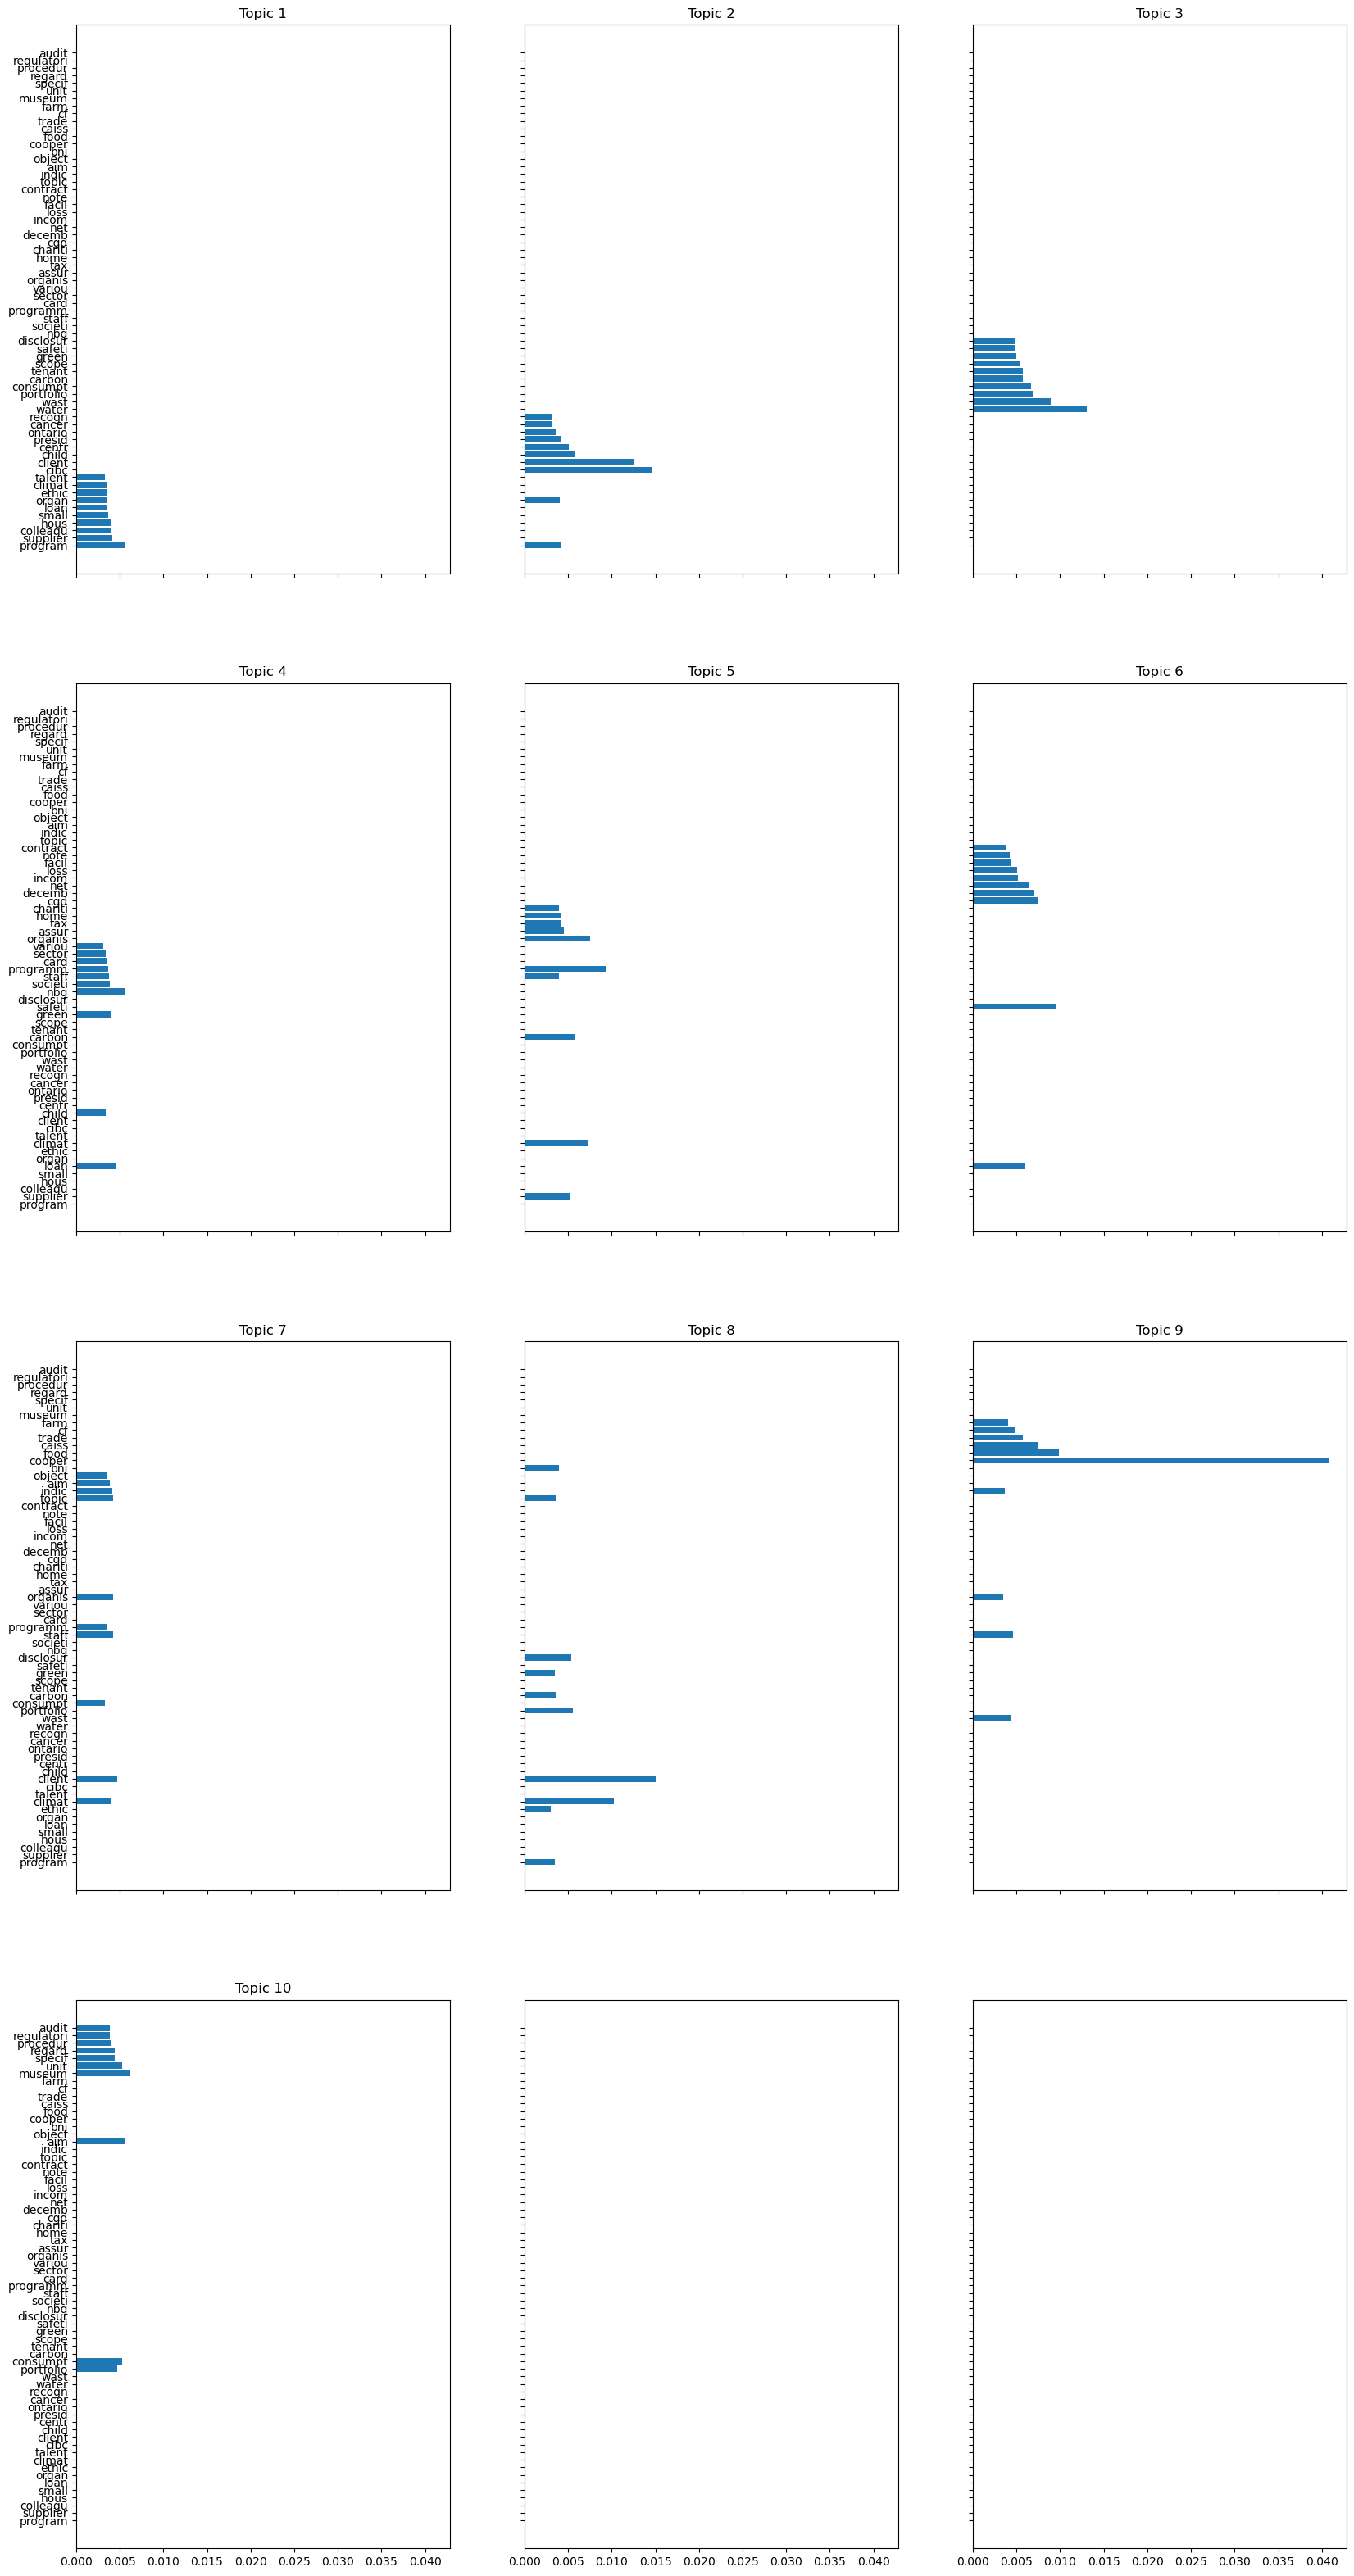

In [80]:
# Plot the topics
topics = lda_model.show_topics(num_topics=10, num_words=10, formatted=False)

fig, axes = plt.subplots(4,3, figsize=(20,40), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    topic_words = dict(topics[i][1])
    ax.barh(list(topic_words.keys()), topic_words.values())
    ax.invert_yaxis()
    ax.set_title('Topic ' + str(i+1))

plt.show()

# lda - loop

In [137]:
start = time.time()
# Define a function to calculate the coherence score for an LDA model
def compute_coherence_score(dictionary, texts, num_topics, no_below, no_above):
    # Remove rare and common terms from the dictionary
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)

    # Create a bag of words representation of the documents
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Train an LDA model
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=42)

    # Compute the coherence score for the model
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    return coherence_score

# Set the range of values to test for each parameter
num_topics_range = [15, 20, 25,30]
no_below_range = [0.2, 0.3 ]
no_above_range = [0.7, 0.8, 0.9]

# Initialize the best parameters and best model
best_params = None
best_model = None
best_score = -1

# Loop over all combinations of parameters
for num_topics in num_topics_range:
    for no_below in no_below_range:
        for no_above in no_above_range:
            # Compute the coherence score for the current parameters
            score = compute_coherence_score(dictionary, texts, num_topics, no_below, no_above)

            # Update the best score and best model if the current score is better
            if score > best_score:
                best_score = score
                best_params = (num_topics, no_below, no_above)
                best_model = LdaModel(corpus=[dictionary.doc2bow(text) for text in texts],
                                      id2word=dictionary,
                                      num_topics=num_topics,
                                      random_state=42)

# Print the best parameters and best coherence score
print(f'Best parameters: num_topics={best_params[0]}, no_below={best_params[1]}, no_above={best_params[2]}')
print(f'Best coherence score: {best_score}')

# Print the topics for the best model
for topic in best_model.print_topics():
    print(topic)

end = time.time()
print("Time taken:", end - start, "seconds") #  2372s

Best parameters: num_topics=15, no_below=0.2, no_above=0.7
Best coherence score: 0.2026189254300595
(0, '0.011*"esg" + 0.006*"gri" + 0.005*"cooper" + 0.004*"programm" + 0.004*"cibc" + 0.004*"organis" + 0.004*"colleagu" + 0.003*"loan" + 0.003*"bond" + 0.002*"csr"')
(1, '0.006*"cooper" + 0.006*"gri" + 0.005*"esg" + 0.004*"programm" + 0.004*"csr" + 0.003*"organis" + 0.003*"digit" + 0.003*"financ" + 0.003*"uk" + 0.002*"center"')
(2, '0.007*"esg" + 0.005*"gri" + 0.004*"cgd" + 0.004*"branch" + 0.003*"programm" + 0.003*"loan" + 0.003*"digit" + 0.003*"organis" + 0.003*"financ" + 0.003*"csr"')
(3, '0.007*"esg" + 0.005*"organis" + 0.004*"loan" + 0.004*"programm" + 0.003*"digit" + 0.003*"cooper" + 0.003*"gri" + 0.003*"financ" + 0.002*"centr" + 0.002*"branch"')
(4, '0.008*"esg" + 0.005*"loan" + 0.005*"programm" + 0.003*"gri" + 0.003*"branch" + 0.003*"cooper" + 0.003*"digit" + 0.003*"csr" + 0.003*"uk" + 0.002*"center"')
(5, '0.006*"esg" + 0.004*"cooper" + 0.004*"programm" + 0.004*"csr" + 0.004*"org

In [ ]:
# next step, get rid of uk, cooper, cibc, nbg, esg,csr,gri, program, organization, center, 

# bert

In [ ]:
# Load BERT from the transformers library
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
# Perform the encoding

def bert_encode(texts, tokenizer, max_len=10000):
    all_tokens = []
    all_masks = []
    all_segments = []
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

# def get_features(texts, model, tokenizer):
#     tokens, masks, segments = bert_encode(texts, tokenizer)
#     with torch.no_grad():
#         inputs = {'input_ids': torch.tensor(tokens),
#                   'attention_mask': torch.tensor(masks),
#                   'token_type_ids': torch.tensor(segments)}
#         features = model(**inputs)
#     return features[-1].mean(dim=1)

def get_features(texts, model, tokenizer):
    input_ids, attention_masks = bert_encode(texts, tokenizer)
    with torch.no_grad():
        features = model(torch.cat(input_ids, dim=0), 
                         torch.cat(attention_masks, dim=0))[0]
    features = features.mean(dim=1)
    return features

In [ ]:
def get_features(texts, model, tokenizer):
    tokens, masks, segments = bert_encode(texts, tokenizer)
    with torch.no_grad():
        inputs = {'input_ids': torch.tensor(tokens),
                  'attention_mask': torch.tensor(masks),
                  'token_type_ids': torch.tensor(segments)}
        hidden_states, pooler_output = model(**inputs)
        features = pooler_output.mean(dim=1)
    return features

In [ ]:
 

# Load the ESG reports data
texts = df['text'].tolist()

# Get features from BERT
features = get_features(texts, model, tokenizer)

# lda

# Stemming and Lemmatization

In [55]:
# apply the stemmer and lemmatizer to the 'col1' column of the DataFrame
df['stemmed'] = df['text_wo_stopwords'].apply(stem_text)
# calculate the average length of strings in the 'col1' column
average_length_stem = df['stemmed'].str.len().mean()
print("stemmed Average length:", average_length_stem) # 

stemmed Average length: 91587.66459074733


In [56]:


df['lemmatized'] = df['text_wo_stopwords'].apply(lemmatize_text)    
average_length_lem = df['lemmatized'].str.len().mean()
# print the result
print("lemmatizedAverage length:", average_length_lem) # 

lemmatizedAverage length: 108521.23754448399


In [57]:
df['stem_lem'] = df['stemmed'].apply(lemmatize_text)    
average_length_stem_lem = df['stem_lem'].str.len().mean()
# print the result
print("stem_lem Average length:", average_length_stem_lem) # 

stem_lem Average length: 91406.25088967971


In [58]:
df['lem_stem'] = df['lemmatized'].apply(stem_text)    
average_length_lem_stem = df['lem_stem'].str.len().mean()
# print the result
print("lem_stem Average length:", average_length_lem_stem) # 91499.74644128114

lem_stem Average length: 91406.25088967971


In [59]:
print("lem_stem Average length:", average_length_lem_stem) # 

lem_stem Average length: 91499.74644128114


In [60]:
df.sample()

,file,text,text_wo_stopwords,stemmed,lemmatized,stem_lem,lem_stem
1099,TSX_TD_2007.pdf,making difference together corporate responsib...,making difference together corporate responsib...,make differ togeth corpor respons report welco...,making difference together corporate responsib...,make differ togeth corpor respons report welco...,make differ togeth corpor respons report welco...


In [61]:

print(df.iloc[4,6]) # display row 5 column 6

abn amro group nv impact report includ integr profit loss impact statement content welcom abn amro impact report report impact statement statement introduct first impact report creat longterm valu stakehold integr profit loss inform requir manag longterm valu stakehold key result long term valu creation impact integr profit loss valu creat stakehold harm contribut sustain develop goal illustr impact provid payment account servic provid mortgag client financ sector industri direct indirect impact integr profit loss statement valu creation statement investor valu creation statement extern cost statement sustain develop goal baselin statement disclosur framework scope boundari data definit methodolog process specif disclosur impact list welcom abn amro impact report welcom abn amro impact report announc refresh strategi new purpos purpos bank better gener come sustain creat longterm valu posit impact key stakehold client employe investor societi larg take longterm valu creation stakehold 

In [62]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
 

# Join the words in the dataframe into a single string
words = " ".join(df["lem_stem"].tolist()) # a quick cell 

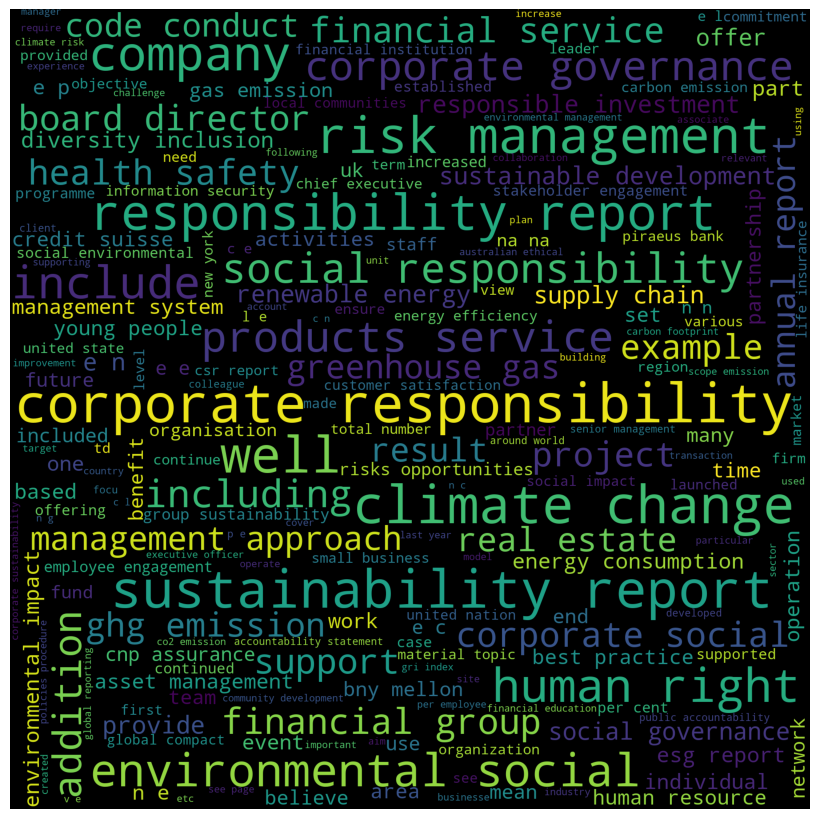

In [16]:
# Generate a word cloud
wordcloud = WordCloud(width=1800, height=1800, min_font_size=10).generate(words)

# Plot the word cloud
plt.figure(figsize=(18, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
plt.show()

In [63]:
from collections import Counter

# Split the string into words
words_s = words.split()

# Count the frequency of each word
word_counts = Counter(words_s)

# Get the top 500 high frequency words
top_500 = word_counts.most_common(500)

# Print the result
print(top_500)
 

[('report', 128846), ('manag', 127632), ('employe', 122574), ('busi', 108530), ('sustain', 97176), ('group', 93499), ('respons', 87026), ('bank', 85973), ('financi', 82596), ('custom', 80333), ('risk', 80066), ('commun', 79969), ('invest', 76972), ('compani', 73786), ('develop', 71997), ('corpor', 71001), ('includ', 69469), ('provid', 68650), ('support', 65611), ('work', 63010), ('servic', 62974), ('year', 61018), ('environment', 57915), ('social', 56947), ('also', 53866), ('govern', 50794), ('oper', 50595), ('new', 48849), ('program', 48648), ('u', 47222), ('impact', 45934), ('inform', 45071), ('product', 44970), ('e', 44248), ('use', 44186), ('help', 44124), ('polici', 43627), ('energi', 43550), ('perform', 42950), ('activ', 39949), ('chang', 39005), ('continu', 38446), ('global', 37998), ('peopl', 37926), ('commit', 37837), ('data', 37713), ('total', 37620), ('engag', 37061), ('board', 34815), ('valu', 34812), ('esg', 34198), ('insur', 34082), ('emiss', 33927), ('train', 33713), ('d

In [25]:
# Get the top 500 high frequency words
top_3500 = [word for word, count in word_counts.most_common(3500)]

# Print the result
# print(top_3500)
# top_3500 

['business', 'employees', 'report', 'management', 'financial', 'group', 'corporate', 'sustainability', 'environmental', 'social', 'also', 'risk', 'customers', 'new', 'bank', 'e', 'energy', 'services', 'development', 'support', 'investment', '1', 'responsibility', 'information', 'governance', 'work', 'year', 'data', '2020', 'performance', 'people', 'community', 'us', 'total', 'company', 'global', 'esg', 'employee', '2019', '2', 'sustainable', 'including', 'impact', 'board', 'emissions', 'n', 'companies', 'program', 'climate', 'communities', 'responsible', 'training', 'insurance', 'products', 'customer', 'health', 'r', 'reporting', 'help', 'environment', '2018', 'policy', 'approach', 'risks', 'change', 'number', 'one', 'across', 'strategy', 'issues', 'clients', 'diversity', 'million', '3', 'annual', 'provide', 'well', 'use', 'activities', 'human', 'key', 'value', '2017', 'committee', 'years', '2016', 'c', 'engagement', 'groups', 'gri', 'banking', 'service', 'p', 'part', '0', 'economic', 

In [ ]:

# extend stopwords 

In [64]:
#  extend stopwords 
import nltk
from nltk.corpus import stopwords
 
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
from nltk.tokenize import word_tokenize

# Get the default stopwords list
stop_words = set(stopwords.words('english'))



In [65]:
# Tokenize the text
tokens = word_tokenize(words)

In [66]:
start = time.time()


# Find the bigrams
finder = BigramCollocationFinder.from_words(tokens)
bigrams = finder.ngram_fd.keys()

# Find the trigrams
finder = TrigramCollocationFinder.from_words(tokens)
trigrams = finder.ngram_fd.keys()

end = time.time()
print("Time taken:", end - start, "seconds") #  110s

Time taken: 94.48986887931824 seconds


In [67]:
# Combine the tokens, bigrams, and trigrams into a list of phrases
phrases = tokens + list(bigrams) + list(trigrams)

# Create a list of the top 1000 most frequent phrases
top_phrases = [item[0] for item in nltk.FreqDist(phrases).most_common(3000)]


# Combine the default stopwords with the frequent phrases
# stopwords = nltk.corpus.stopwords.words('english') + top_phrases # not yet, need to manully process them 

In [68]:
print(top_phrases) # too many numbers

['report', 'manag', 'employe', 'busi', 'sustain', 'group', 'respons', 'bank', 'financi', 'custom', 'risk', 'commun', 'invest', 'compani', 'develop', 'corpor', 'includ', 'provid', 'support', 'work', 'servic', 'year', 'environment', 'social', 'also', 'govern', 'oper', 'new', 'program', 'u', 'impact', 'inform', 'product', 'e', 'use', 'help', 'polici', 'energi', 'perform', 'activ', 'chang', 'continu', 'global', 'peopl', 'commit', 'data', 'total', 'engag', 'board', 'valu', 'esg', 'insur', 'emiss', 'train', 'divers', 'initi', 'build', 'client', 'intern', 'market', 'process', 'n', 'issu', 'strategi', 'climat', 'offic', 'improv', 'project', 'opportun', 'environ', 'approach', 'r', 'number', 'health', 'well', 'standard', 'make', 'stakehold', 'fund', 'need', 'annual', 'committe', 'ethic', 'financ', 'increas', 'member', 'million', 'one', 'area', 'team', 'organ', 'gener', 'system', 'offer', 'practic', 'conduct', 'materi', 'ensur', 'addit', 'page', 'across', 'c', 'plan', 'relat', 'time', 'secur', 'r

In [38]:
top_phrases_nonum = list_without_numbers = [item for item in top_phrases if not item.isdigit()]

In [39]:
print(top_phrases_nonum)

['business', 'employees', 'report', 'management', 'financial', 'group', 'corporate', 'sustainability', 'environmental', 'social', 'also', 'risk', 'customers', 'new', 'bank', 'e', 'energy', 'services', 'development', 'support', 'investment', 'responsibility', 'information', 'governance', 'work', 'year', 'data', 'performance', 'people', 'community', 'us', 'total', 'company', 'global', 'esg', 'employee', 'sustainable', 'including', 'impact', 'board', 'emissions', 'n', 'companies', 'program', 'climate', 'communities', 'responsible', 'training', 'insurance', 'products', 'customer', 'health', 'r', 'reporting', 'help', 'environment', 'policy', 'approach', 'risks', 'change', 'number', 'one', 'across', 'strategy', 'issues', 'clients', 'diversity', 'million', 'annual', 'provide', 'well', 'use', 'activities', 'human', 'key', 'value', 'committee', 'years', 'c', 'engagement', 'groups', 'gri', 'banking', 'service', 'p', 'part', 'economic', 'credit', 'operations', 'capital', 'opportunities', 'complia

In [40]:
# only show that are not in cntk stopwords
stopwords = set(nltk.corpus.stopwords.words("english"))

 

filtered_words = [word for word in top_phrases_nonum if word not in stopwords]

print(filtered_words)


['business', 'employees', 'report', 'management', 'financial', 'group', 'corporate', 'sustainability', 'environmental', 'social', 'also', 'risk', 'customers', 'new', 'bank', 'e', 'energy', 'services', 'development', 'support', 'investment', 'responsibility', 'information', 'governance', 'work', 'year', 'data', 'performance', 'people', 'community', 'us', 'total', 'company', 'global', 'esg', 'employee', 'sustainable', 'including', 'impact', 'board', 'emissions', 'n', 'companies', 'program', 'climate', 'communities', 'responsible', 'training', 'insurance', 'products', 'customer', 'health', 'r', 'reporting', 'help', 'environment', 'policy', 'approach', 'risks', 'change', 'number', 'one', 'across', 'strategy', 'issues', 'clients', 'diversity', 'million', 'annual', 'provide', 'well', 'use', 'activities', 'human', 'key', 'value', 'committee', 'years', 'c', 'engagement', 'groups', 'gri', 'banking', 'service', 'p', 'part', 'economic', 'credit', 'operations', 'capital', 'opportunities', 'complia

In [69]:
# Add your own stopwords to the list
custom_stopwords = ['business',   'report',    'group', 'corporate',   'also',   'new',   'e',   'work', 'year',   'us', 'total', 
                    'company',    'including',   'n', 'companies', 'program',  'programm', 'r',   'toronto', 'greek','number',
                    'one','two', 'three','four','five','six','seven','eight','nine','ten',
                    'across', 'among','provide', 'well', 'group','page','net', 'cathey', 'v','meeting','na','percent','ways',
                    'use',  'c',   'groups',  'p', 'part',   'practices', 'team',    'working',   'businesses', 'ensure',   
                    'within',  'l',    'f', 'via','r','would','other','without','take', 'k','eg', 'allow','make','x','much',
                    'areas',   'per', 'make',   'since',   'see',   'made',   'set', 'better', 'used',    
                    'fi',   'general',   'due', 'many', 'still','especially','july','¾','june','turn', 'fy20',
                    'following',  'supporting', 'every','became']

stop_words.update(custom_stopwords)

# Use the updated stopwords list in your code
filtered_words = [word for word in words if word.lower() not in stop_words]


In [70]:
start = time.time()

# Create bigrams and trigrams
bigram = CountVectorizer(ngram_range=(2,2), min_df=5, max_df=0.9)
trigram = CountVectorizer(ngram_range=(3,3), min_df=5, max_df=0.9)
bigram_matrix = bigram.fit_transform(df['stem_lem'])
trigram_matrix = trigram.fit_transform(df['stem_lem'])


end = time.time()
print("Time taken:", end - start, "seconds") # did not show the time

Time taken: 58.870169162750244 seconds


In [72]:
start = time.time()


# Create a list of ESG and finance keywords
keywords = ["sustainability", "climate change", "renewable energy", "carbon footprint",
            "water management", "waste management", "biodiversity", "human rights",
            "labor practices", "corporate governance", "ethical sourcing", "diversity and inclusion",
            "transparency", "esg ratings", "impact investing", "green bonds", "sustainable finance",
            "responsible investing", "esg risks", "esg disclosure"]


# Add bigrams and trigrams to the list of keywords
keywords.extend(bigram.get_feature_names_out())
keywords.extend(trigram.get_feature_names_out())

# Create a dictionary of the keywords
dictionary = Dictionary([keywords])

# Convert the cleaned text to a bag of words representation
bow_corpus = [dictionary.doc2bow(text.split()) for text in df['stem_lem']]


end = time.time()
print("Time taken:", end - start, "seconds") # ime taken: 2.134260416030884 seconds

Time taken: 8.332211017608643 seconds


In [73]:
start = time.time()

# Train the LDA model
lda = LdaModel(bow_corpus, num_topics=30, id2word=dictionary, passes=10)

# Print the topics generated by the model
for idx, topic in lda.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))

end = time.time()
print("Time taken:", end - start, "seconds") #  

C:\Users\myin9\anaconda3\lib\site-packages\gensim\models\ldamodel.py:846: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)
C:\Users\myin9\anaconda3\lib\site-packages\gensim\models\ldamodel.py:846: RuntimeWarning: invalid value encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


Topic: 0 
Words: 0.000*"period report form" + 0.000*"period report januari" + 0.000*"period renew" + 0.000*"period report" + 0.000*"period report activ" + 0.000*"period report board" + 0.000*"period report cover" + 0.000*"period report cycl" + 0.000*"period report date" + 0.000*"period remind duti"
Topic: 1 
Words: 0.000*"period report form" + 0.000*"period report januari" + 0.000*"period renew" + 0.000*"period report" + 0.000*"period report activ" + 0.000*"period report board" + 0.000*"period report cover" + 0.000*"period report cycl" + 0.000*"period report date" + 0.000*"period remind duti"
Topic: 2 
Words: 0.000*"period report form" + 0.000*"period report januari" + 0.000*"period renew" + 0.000*"period report" + 0.000*"period report activ" + 0.000*"period report board" + 0.000*"period report cover" + 0.000*"period report cycl" + 0.000*"period report date" + 0.000*"period remind duti"
Topic: 3 
Words: 0.000*"period report form" + 0.000*"period report januari" + 0.000*"period renew" +

In [ ]:
 

n_topics = 30 # number of topics to extract

# Get the features from the texts
text_features = get_features(df['text'].tolist(), model, tokenizer)

# Initialize the LDA model
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)

# Fit the LDA model to the text features
lda.fit(text_features)


In [ ]:
# Encode the text data using BERT
encoded_text = bert_encode(df['text'].tolist(), tokenizer, max_length= 10000)

# Get features from the encoded text data
features = get_features(encoded_text)


In [ ]:
# Use the encoded data for topic modeling
def run_topic_modeling(data, model, tokenizer, n_topics=30, algorithm="nmf"):
    if algorithm == "nmf":
        nmf = NMF(n_components=n_topics, random_state=0)
        W = nmf.fit_transform(data)
        H = nmf.components_
    else:
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
        W = lda.fit_transform(data)
        H = lda.components_
    return W, H

In [ ]:
texts = df['text'].tolist()
data = get_features(texts, model, tokenizer)
W, H = run_